All used libraries are show imported in the following code block.

In [197]:
import scipy.stats as stats
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import geopandas as gpd
import seaborn as sns
import colorcet as cc
import fsspec
import math

import matplotlib.pyplot as plt


In [198]:
data = pd.read_csv('cleaned_data/cleaned.csv')
data.head()

,source_airline_country,source_airport_ID,source_airport_name,source_airport_city,source_airport_country,source_airport_lat,source_airport_long,source_airport_alt,destination_airport_ID,destination_airport_name,...,destination_airport_alt,airline_ID,airline_name,route_stops,IATA Code,icao_code,aircraft_name,aircraft_general_make,aircraft_company,airbus_boeing_other
0,Portugal,2965.0,Sochi International Airport,Sochi,Russia,43.449902,39.956600,89.0,2990.0,Kazan International Airport,...,411.0,410,Aerocondor,0,CR2,CRJ2,Canadair Regional Jet 200,CRJ2,Canadair,Other
1,Portugal,2966.0,Astrakhan Airport,Astrakhan,Russia,46.283298,48.006302,-65.0,2990.0,Kazan International Airport,...,411.0,410,Aerocondor,0,CR2,CRJ2,Canadair Regional Jet 200,CRJ2,Canadair,Other
2,Portugal,2966.0,Astrakhan Airport,Astrakhan,Russia,46.283298,48.006302,-65.0,2962.0,Mineralnyye Vody Airport,...,1054.0,410,Aerocondor,0,CR2,CRJ2,Canadair Regional Jet 200,CRJ2,Canadair,Other
3,Portugal,2968.0,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,55.305801,61.503300,769.0,2990.0,Kazan International Airport,...,411.0,410,Aerocondor,0,CR2,CRJ2,Canadair Regional Jet 200,CRJ2,Canadair,Other
4,Portugal,2968.0,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,55.305801,61.503300,769.0,4078.0,Tolmachevo Airport,...,365.0,410,Aerocondor,0,CR2,CRJ2,Canadair Regional Jet 200,CRJ2,Canadair,Other


Below are some useful definitions that will be used later in the analysis of the data.

In [199]:

def t_test(group1, group2):
    t_statistic, p_value = stats.ttest_ind(group1, group2)

    print("T-statistic:", t_statistic)
    print("P-value:", p_value)

    alpha = 0.05  # Significance level
    if p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between the groups.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the groups.")

    return(t_statistic, p_value)



def linear_regression(data, features, target):
    X = data[features]
    y = data[target]

    model = LinearRegression()

    model.fit(X, y)

    coefficients = model.coef_
    intercept = model.intercept_
    r_squared = model.score(X, y)

    print("Coefficients", coefficients)
    print("Intercept", intercept)
    print("R-Squared", r_squared)

    return coefficients, intercept, r_squared

def logistic_regression(dataset, features, target, test_size=0.2, random_state=42): # Note random state will always be set to 42 in our analysis
    X = data[features]
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    confusion = confusion_matrix(y_test, y_pred)

    print("Confusion Matrix", confusion)

    return confusion

Below are some definitions for basic visuals that can be used.

In [284]:
def stacked_bar_chart(data, title=None, xlabel=None, ylabel=None, legend_labels=None):

    # Create figure and axis
    fig, ax = plt.subplots()

    data.plot(kind='bar', stacked=True, ax=ax, color = sns.color_palette("Set2"))

    # Add title, label, legend
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if legend_labels:
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    return fig

def create_histograms(data, category_column, value_column, bins=10, colors=None, title=None, xlabel=None, ylabel=None):
    # If colors are not provided, use a default list of colors
    if colors is None:
        colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow']

    # Get unique categories (aircraft companies)
    categories = data[category_column].unique()
    total_frequencies = data[category_column].value_counts()

    categories = sorted(categories, key=lambda category: -total_frequencies[category])

    # Calculate the number of rows and columns for subplots
    num_rows = (len(categories) + 1) // 2  # Adjust the number of rows as needed
    num_cols = 2  # Number of columns per row

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    fig.tight_layout(pad=3.0)

    # Plot histograms for each category (aircraft company) on separate axes
    for i, category in enumerate(categories):
        row, col = i // num_cols, i % num_cols
        color = colors[i % len(colors)]  # Cycle through colors if there are more categories than colors
        category_data = data[data[category_column] == category]
        axes[row, col].hist(category_data[value_column], bins=bins, color=color, alpha=0.5)
        axes[row, col].set_title(category)

        total_frequency = total_frequencies[category]
        axes[row, col].text(0.8, 0.8, f'Total: {total_frequency}', transform=axes[row, col].transAxes,
                            bbox=dict(facecolor='white', alpha=0.5))

    # Add common title and labels
    if title:
        fig.suptitle(title)
    if xlabel:
        for ax in axes[-1, :]:
            ax.set_xlabel(xlabel)
    if ylabel:
        for ax in axes[:, 0]:
            ax.set_ylabel(ylabel)

    return fig

def create_scatterplot(x, y, color='blue', title=None, xlabel=None, ylabel=None):
    # Create figure and axis
    fig, ax = plt.subplots()

    # Plot the scatterplot
    ax.scatter(x, y, color=color)

    # Add title and label
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

    return fig

def create_colored_world_map(data, country_col, feature, legend_title ='Aircraft Company',
                              title="World Map Colored by Most Used Aircraft Company"):

    url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/" \
      "download/110m/cultural/ne_110m_admin_0_countries.zip"
    
    with fsspec.open(f"simplecache::{url}") as file:
        world = gpd.read_file(file)

    # Changing the world dataset to have the same Country names as the cleaned dataset.
    world['SOVEREIGNT'] = world['SOVEREIGNT'].replace("United States of America","United States")
    world['SOVEREIGNT'] = world['SOVEREIGNT'].replace("Democratic Republic of the Congo","Republic of the Congo",)
    world['SOVEREIGNT'] = world['SOVEREIGNT'].replace("Congo - Kinshasa","Congo (Kinshasa)")
    world['SOVEREIGNT'] = world['SOVEREIGNT'].replace("Czech Republic","Czech Republic")

    world = world.merge(data, left_on='SOVEREIGNT', right_on=country_col)
    fig, ax = plt.subplots(figsize=(15, 10))
    world.boundary.plot(ax=ax, linewidth=1, color='k')
    palette = sns.color_palette(cc.glasbey)

    legend_artists = []
    legend_labels = []

    for i, company in enumerate(world[feature].unique()):
        subset = world[world[feature] == company]
        subset.plot(ax=ax, color=palette[i], label=company)

        legend_artists.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10))
        legend_labels.append(company)

    ax.legend(legend_artists, legend_labels, title = legend_title, loc='lower left')

    ax.set_title(title)


    return fig

In [285]:
# Function to calculate distance using Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    # Radius of the Earth in kilometers
    radius = 6371 
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c
    
    return distance

data['distance'] = data.apply(lambda row: haversine_distance(row['source_airport_lat'], 
                                                             row['source_airport_long'], 
                                                             row['destination_airport_lat'], 
                                                             row['destination_airport_long']), axis=1)

In [286]:
data['route'] = data['source_airport_name'] + " to " + data['destination_airport_name']

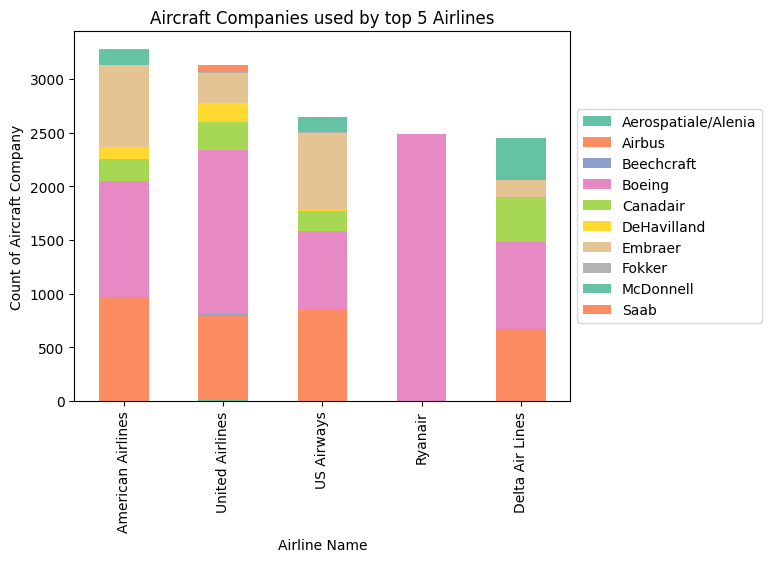

In [287]:
# Pivot the DataFrame to get counts of 'make' per 'airline'
pivot_df = data.pivot_table(index='airline_name', columns='aircraft_company', aggfunc='size', fill_value=0)
# Calculate the total count of routes for each airline
pivot_df['Total'] = pivot_df.sum(axis=1)

# Sort the DataFrame by the total count in descending order
pivot_df = pivot_df.sort_values(by='Total', ascending=False)
pivot_df = pivot_df.head(5)
pivot_df = pivot_df.loc[:, (pivot_df != 0).any(axis=0)]


fig = stacked_bar_chart(pivot_df.drop(columns='Total'), xlabel='Airline Name', ylabel='Count of Aircraft Company', 
                        title='Aircraft Companies used by top 5 Airlines', legend_labels='Aircraft Company')
plt.show()

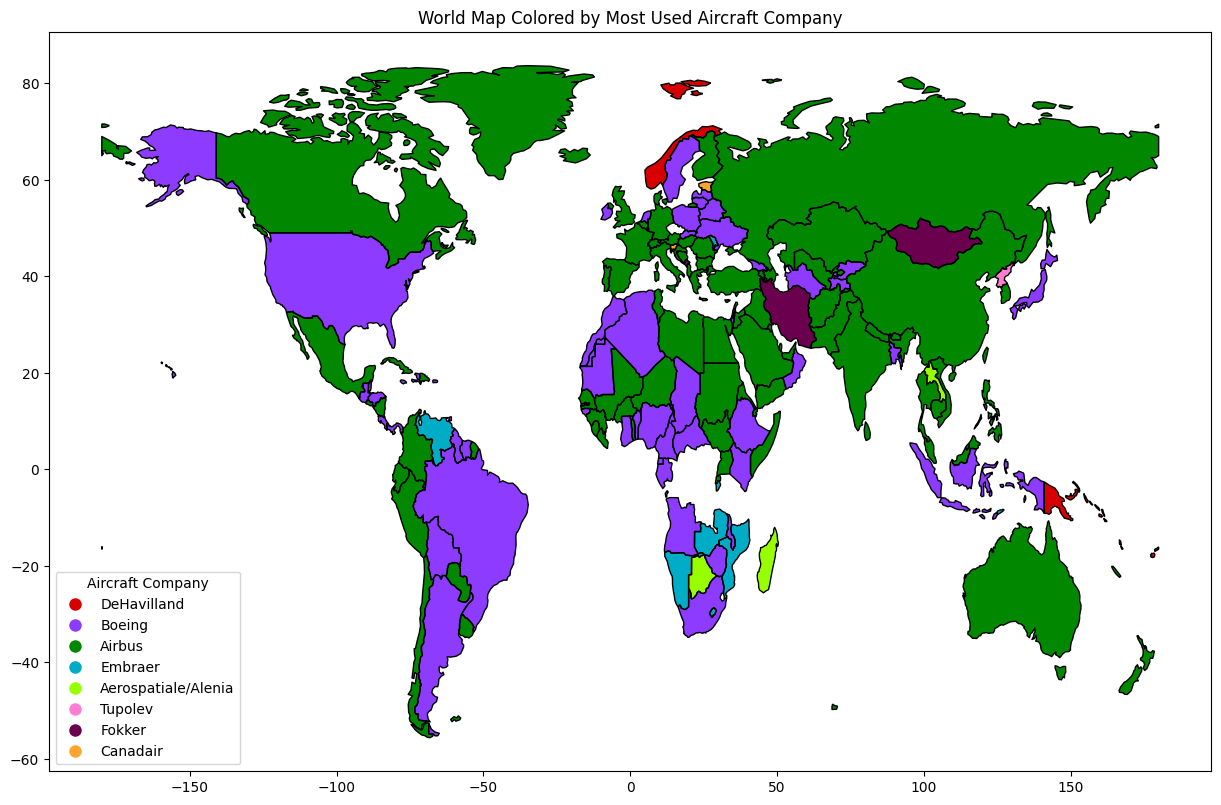

In [288]:
pivot_df = data.pivot_table(index='source_airport_country', columns='aircraft_company', aggfunc='size', fill_value=0)
pivot_df['MostUsedCompany'] = pivot_df.idxmax(axis=1)
pivot_df = pivot_df.reset_index()

create_colored_world_map(pivot_df, country_col='source_airport_country', feature='MostUsedCompany', legend_title ='Aircraft Company',
                         title="World Map Colored by Most Used Aircraft Company")
plt.show()


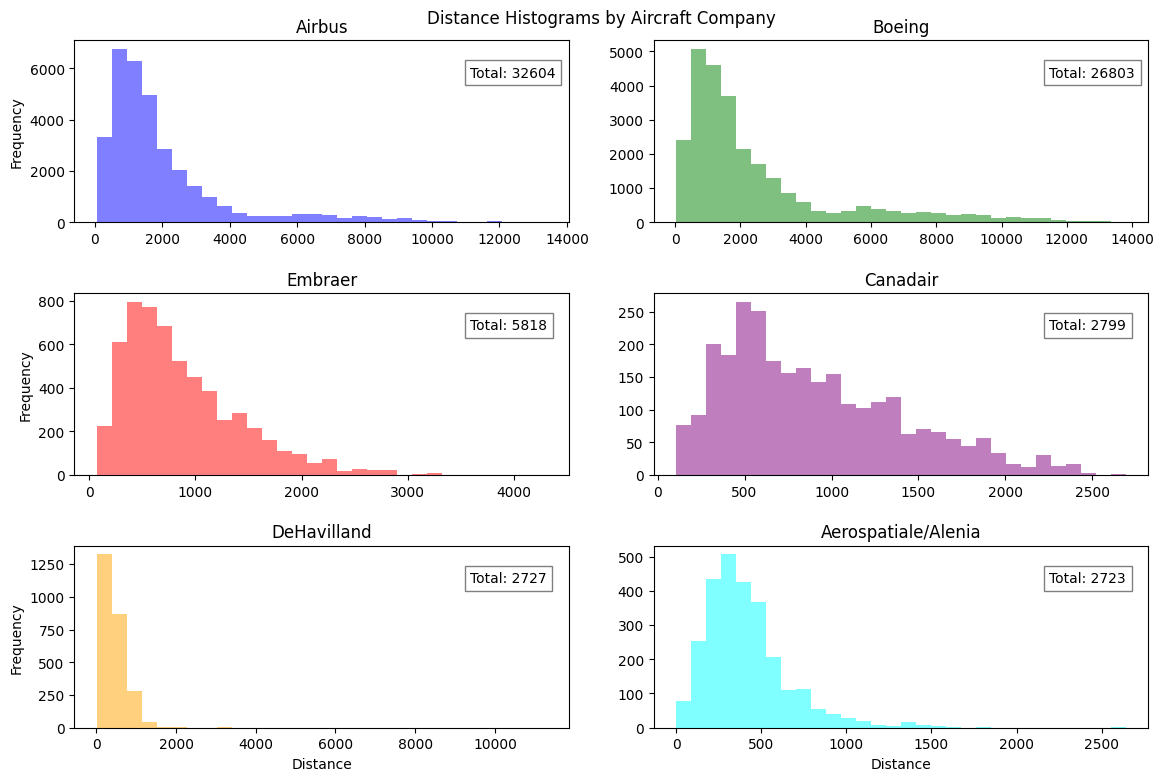

In [289]:
top_airlines = data['aircraft_company'].value_counts().nlargest(6).index

# Filter data to include only rows corresponding to the top airlines
filtered_data = data[data['aircraft_company'].isin(top_airlines)]

create_histograms(filtered_data, category_column='aircraft_company', value_column='distance', 
                  title="Distance Histograms by Aircraft Company", xlabel="Distance", 
                  ylabel="Frequency", bins=30)
plt.show()